In [ ]:
#@title Copyright 2020 Google LLC. Double-click here for license information.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Colabs

Machine Learning Crash Course uses Colaboratories (Colabs) for all programming exercises. Colab is Google's implementation of [Jupyter Notebook](https://jupyter.org/). For more information about Colabs and how to use them, go to [Welcome to Colaboratory](https://research.google.com/colaboratory).

# Introduction to Neural Nets

This Colab builds a deep neural network to perform more sophisticated linear regression than the earlier Colabs.

## Learning Objectives:

After doing this Colab, you'll know how to do the following:

  * Create a simple deep neural network.
  * Tune the hyperparameters for a simple deep neural network.

## The Dataset
  
Like several of the previous Colabs, this Colab uses the [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

## Import relevant modules

The following hidden code cell imports the necessary code to run the code in the rest of this Colaboratory.

In [2]:
#@title Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

Imported modules.


## Load the dataset

Like most of the previous Colab exercises, this exercise uses the California Housing Dataset.  The following code cell loads the separate .csv files and creates the following two pandas DataFrames:

* `train_df`, which contains the training set
* `test_df`, which contains the test set
   

In [3]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the examples
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

In [5]:
print(train_df.head())
print(test_df.head())

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4204      -118.0      33.7                18.0       1994.0           578.0   
16627     -122.7      38.4                30.0       2099.0           406.0   
7665      -118.4      33.9                27.0       1688.0           331.0   
1820      -117.3      34.2                16.0         30.0             3.0   
1095      -117.1      32.7                37.0       2045.0           502.0   

       population  households  median_income  median_house_value  
4204       3031.0       577.0            2.8            237500.0  
16627      1156.0       401.0            2.8            152300.0  
7665        811.0       327.0            4.5            334200.0  
1820         49.0         8.0            4.6            250000.0  
1095       1920.0       472.0            1.8             83300.0  
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0     -122.0      37.4                27.0      

## Represent data

The following code cell creates preprocessing layers outputting three features:

* `latitude` X `longitude` (a feature cross)
* `median_income`
* `population`

This code cell specifies the features that you'll ultimately train the model on and how each of those features will be represented. The transformations (collected in `prepocessing_layers`) don't actually get applied until you pass a DataFrame to it, which will happen when we train the model.

We'll use `preprocessing_layers` for both our linear regression model and our neural network model.

(The [`keras.FeatureSpace`](https://keras.io/examples/structured_data/structured_data_classification_with_feature_space) utility offers an alternative to building individual Keras preprocessing layers -- give it a try, if you're feeling adventurous!)

In [12]:
# Keras Input tensors of float values.
# 每個輸入層的形狀為 (1,)，即每個樣本只有一個值，數據類型為 tf.float32。
inputs = {
    'latitude':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='latitude'),
    'longitude':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='longitude'),
    'median_income':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='median_income'),
    'population':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='population')
}

# Normalization 層來標準化中位數收入和人口數據。這些層會學習訓練數據的平均值和標準差，並將其應用於輸入數據。
# Create a Normalization layer to normalize the median_income data.
median_income = tf.keras.layers.Normalization(name='normalization_median_income',axis=None)
# median_income.adapt(train_df['median_income'])
median_income.adapt(np.array(train_df['median_income']))
median_income = median_income(inputs.get('median_income'))

# Create a Normalization layer to normalize the population data.
population = tf.keras.layers.Normalization(name='normalization_population',axis=None)
# population.adapt(train_df['population'])
population.adapt(np.array(train_df['population']))
population = population(inputs.get('population'))


# 緯度和經度的正規化和離散化
# Create a list of numbers representing the bucket boundaries for latitude.
# Because we're using a Normalization layer, values for latitude and longitude
# will be in the range of approximately -3 to 3 (representing the Z score).
# We'll create 20 buckets, which requires 21 bucket boundaries (hence, 20+1).
# np.linspace 函數用於生成在指定範圍內的等間距數值，將緯度數據分成桶（buckets）的邊界。
# start：序列的開始值。
# stop：序列的結束值。
# num：生成的數值個數，包括 start 和 stop，ex.生成的數值個數是 21（即 20+1）因為要創建20個桶，需要21個邊界值。
latitude_boundaries = np.linspace(-3, 3, 20+1).tolist()

# Create a Normalization layer to normalize the latitude data.
latitude = tf.keras.layers.Normalization(name='normalization_latitude',axis=None)
latitude.adapt(np.array(train_df['latitude']))
latitude = latitude(inputs.get('latitude'))


# Create a Discretization layer to separate the latitude data into buckets.
latitude = tf.keras.layers.Discretization(
    bin_boundaries=latitude_boundaries,
    name='discretization_latitude')(latitude)

# Create a list of numbers representing the bucket boundaries for longitude.
longitude_boundaries = np.linspace(-3, 3, 20+1).tolist()

# Create a Normalization layer to normalize the longitude data.
longitude = tf.keras.layers.Normalization(name='normalization_longitude',axis=None)
longitude.adapt(np.array(train_df['longitude']))
longitude = longitude(inputs.get('longitude'))

# Create a Discretization layer to separate the longitude data into buckets.
longitude = tf.keras.layers.Discretization(
    bin_boundaries=longitude_boundaries,
    name='discretization_longitude')(longitude)

# Cross the latitude and longitude features into a single one-hot vector.
# 使用 HashedCrossing 層對緯度和經度特徵進行交叉處理，將其轉換為單個 one-hot 向量
# num_bins 表示哈希桶的數量，可以調整以平衡精度和性能。
feature_cross = tf.keras.layers.HashedCrossing(
    # num_bins can be adjusted: Higher values improve accuracy, lower values
    # improve performance.
    num_bins=len(latitude_boundaries) * len(longitude_boundaries),
    output_mode='one_hot',
    name='cross_latitude_longitude')([latitude, longitude])

# Concatenate our inputs into a single tensor.
# 串聯輸入層，將處理後的緯度和經度交叉特徵、中位數收入和人口數據串聯成一個單一的張量，這個張量將作為模型的輸入。
preprocessing_layers = tf.keras.layers.Concatenate()(
    [feature_cross, median_income, population])

print("Preprocessing layers defined.")

Preprocessing layers defined.


In [13]:
print(np.array(train_df['population']))

[1338.  754.  753. ... 3847. 1103. 1755.]


In [14]:
print(train_df['population'])

1939    1338.0
6417     754.0
9893     753.0
1131    1392.0
3262    3356.0
         ...  
12199   1789.0
6181     125.0
7701    3847.0
6770    1103.0
13125   1755.0
Name: population, Length: 17000, dtype: float64


In [15]:
feature_cross

<KerasTensor shape=(None, 441), dtype=float32, sparse=False, name=keras_tensor_22>

In [16]:
latitude

<KerasTensor shape=(None, 1), dtype=int64, sparse=False, name=keras_tensor_19>

## Build a linear regression model as a baseline

Before creating a deep neural net, find a [baseline](https://developers.google.com/machine-learning/glossary/#baseline) loss by running a simple linear regression model that uses the preprocessing layers you just created.


## Define the plotting function.

In [17]:
def plot_the_loss_curve(epochs, mse_training, mse_validation):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse_training, label="Training Loss")
  plt.plot(epochs, mse_validation, label="Validation Loss")

  # mse_training is a pandas Series, so convert it to a list first.
  merged_mse_lists = mse_training.tolist() + mse_validation
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  top_of_y_axis = highest_loss * 1.03
  bottom_of_y_axis = lowest_loss * 0.97

  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.legend()
  plt.show()

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


## Define functions to create and train a linear regression model

In [18]:
def create_model(my_inputs, my_outputs, my_learning_rate):
  """Create and compile a simple linear regression model."""
  model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.Adam(
      learning_rate=my_learning_rate),
      loss="mean_squared_error",
      metrics=[tf.keras.metrics.MeanSquaredError()])

  return model


def train_model(model, dataset, epochs, batch_size, label_name, validation_split=0.1):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = train_median_house_value_normalized(
      np.array(features.pop(label_name)))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, validation_split=validation_split)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse, history.history

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


## Define normalized label columns
Create Normalization layers to normalize the median_house_value data.Because median_house_value is our label (i.e., the target value we're predicting), these layers won't be added to our model.  
創建標準化層以標準化 median_house_value 資料。由於 median_house_value 是我們的標籤（即要預測的目標值），這些層不會被添加到我們的模型中。  
* 提高模型的穩定性和性能：標準化可以讓模型更快收斂，並且可以提高預測的準確性。這是因為標準化可以讓數據的範圍更小，避免因為數值差異過大而影響模型的學習過程。

* 避免數值問題：如果數據範圍過大，可能會引起數值不穩定或溢出等問題，特別是在使用梯度下降法進行優化的過程中。

In [19]:
# 創建標準化層 (Normalization layer)
# axis=None 表示對整個張量進行標準化。
train_median_house_value_normalized = tf.keras.layers.Normalization(axis=None)
# 適配標準化層 (adapt method)
# adapt 方法會計算訓練集 median_house_value 資料的均值和標準差。這樣，標準化層就可以使用這些統計值來轉換資料。
train_median_house_value_normalized.adapt(
    np.array(train_df['median_house_value']))

test_median_house_value_normalized = tf.keras.layers.Normalization(axis=None)
test_median_house_value_normalized.adapt(
    np.array(test_df['median_house_value']))


In [20]:
train_median_house_value_normalized

<Normalization name=normalization_7, built=True>

## Define linear regression model outputs


In [21]:
def get_outputs_linear_regression():
  # Create the Dense output layer.
  dense_output = tf.keras.layers.Dense(units=1,
                              name='dense_output')(preprocessing_layers)

  # Define an output dictionary we'll send to the model constructor.
  outputs = {
    'dense_output': dense_output
  }
  return outputs

Run the following code cell to invoke the functions defined in the preceding two code cells. (Ignore the warning messages.)

**Note:** Because we've scaled all the input data, **including the label**, the resulting loss values will be *much less* than models in previous Colabs (e.g., [Representation with a Feature Cross](https://colab.sandbox.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/representation_with_a_feature_cross.ipynb)).

**Note:** Depending on the version of TensorFlow, running this cell might generate WARNING messages. Please ignore these warnings.

Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.0362 - mean_squared_error: 1.0362 - val_loss: 1.0061 - val_mean_squared_error: 1.0061
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0122 - mean_squared_error: 1.0122 - val_loss: 1.0009 - val_mean_squared_error: 1.0009
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0117 - mean_squared_error: 1.0117 - val_loss: 0.9995 - val_mean_squared_error: 0.9995
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0021 - mean_squared_error: 1.0021 - val_loss: 0.9988 - val_mean_squared_error: 0.9988
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9954 - mean_squared_error: 0.9954 - val_loss: 0.9981 - val_mean_squared_error: 0.9981
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9924 - mean_squared_error: 0.9924 - val_loss: 0.9973 - val_mean_squared_error: 0.9973
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0106 - mean_squared_error: 1.0106 - val_loss: 0.9987 - val_mean

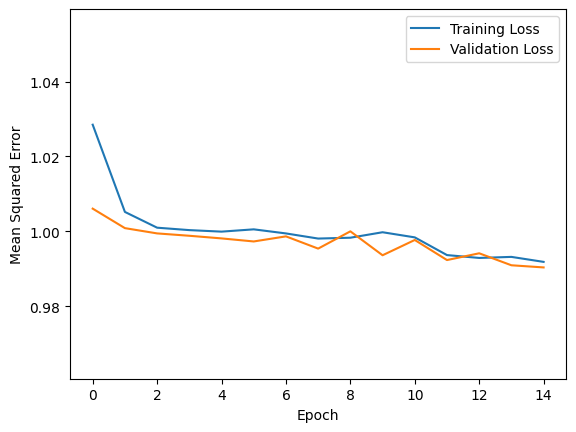


 Evaluate the linear regression model against the test set:
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9773 - mean_squared_error: 0.9773 


{'loss': 0.9946836233139038, 'mean_squared_error': 0.9946836233139038}

In [25]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"

# Split the original training set into a reduced training set and a
# validation set.
validation_split = 0.2

outputs = get_outputs_linear_regression()

# Establish the model's topography.
my_model = create_model(inputs, outputs, learning_rate)

# Train the model on the normalized training set.
epochs, mse, history = train_model(my_model, train_df, epochs, batch_size,
                          label_name, validation_split)
plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])

test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = test_median_house_value_normalized(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size, return_dict=True)

## Define a deep neural net model

The `get_outputs_dnn` function defines the topography of the deep neural net (DNN), specifying the following:

* The number of [layers](https://developers.google.com/machine-learning/glossary/#layer) in the deep neural net.
* The number of [nodes](https://developers.google.com/machine-learning/glossary/#node) in each layer.

The `get_outputs_dnn` function also defines the [activation function](https://developers.google.com/machine-learning/glossary/#activation_function) of each layer.

The first `Dense` layer takes our previously defined `preprocessing_layers` as input.

In [26]:
def get_outputs_dnn():
  # Create a Dense layer with 20 nodes.
  dense_output = tf.keras.layers.Dense(units=20,
                              activation='relu',
                              name='hidden_dense_layer_1')(preprocessing_layers)
  # Create a Dense layer with 12 nodes.
  dense_output = tf.keras.layers.Dense(units=12,
                              activation='relu',
                              name='hidden_dense_layer_2')(dense_output)
  # Create the Dense output layer.
  dense_output = tf.keras.layers.Dense(units=1,
                              name='dense_output')(dense_output)

  # Define an output dictionary we'll send to the model constructor.
  outputs = {
    'dense_output': dense_output
  }

  return outputs

## Call the functions to build and train a deep neural net

Okay, it is time to actually train the deep neural net.  If time permits, experiment with the three hyperparameters to see if you can reduce the loss
against the test set.


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.0086 - mean_squared_error: 1.0086 - val_loss: 0.9976 - val_mean_squared_error: 0.9976
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0069 - mean_squared_error: 1.0069 - val_loss: 0.9971 - val_mean_squared_error: 0.9971
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0055 - mean_squared_error: 1.0055 - val_loss: 0.9992 - val_mean_squared_error: 0.9992
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0148 - mean_squared_error: 1.0148 - val_loss: 0.9966 - val_mean_squared_error: 0.9966
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0019 - mean_squared_error: 1.0019 - val_loss: 0.9959 - val_mean_squared_error: 0.9959
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9966 - mean_squared_error: 0.9966 - val_loss: 0.9953 - val_mean_squared_error: 0.9953
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0018 - mean_squared_error: 1.0018 - val_loss: 0.9963 - val_mean

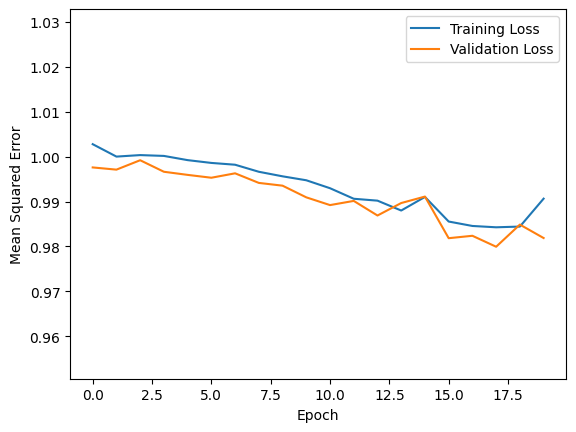


 Evaluate the new model against the test set:
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9686 - mean_squared_error: 0.9686 


{'loss': 0.9873665571212769, 'mean_squared_error': 0.9873665571212769}

In [29]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label
label_name = "median_house_value"

# Split the original training set into a reduced training set and a
# validation set.
validation_split = 0.2

dnn_outputs = get_outputs_dnn()

# Establish the model's topography.
my_model = create_model(
    inputs,
    dnn_outputs,
    learning_rate)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined in our inputs.
epochs, mse, history = train_model(my_model, train_df, epochs,
                                   batch_size, label_name, validation_split)
plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = test_median_house_value_normalized(np.array(test_features.pop(label_name))) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size, return_dict=True)

## Task 1: Compare the two models

How did the deep neural net perform against the baseline linear regression model?  
假設線性模型和深度神經網路模型都已經收斂，比較每個模型在測試集上的損失。
實驗中，深度神經網路模型的損失值總是比線性回歸模型的損失值低，這意味著深度神經網路模型將會比線性回歸模型做出更好的預測。


## Task 2: Optimize the deep neural network's topography

Experiment with the number of layers of the deep neural network and the number of nodes in each layer.  Aim to achieve both of the following goals:

*  Lower the loss against the test set.
*  Minimize the overall number of nodes in the deep neural net.

The two goals may be in conflict.  

趨勢：
* 兩層網路 的表現優於一層網路，但三層網路的表現並沒有顯著優於兩層網路。換句話說，兩層網路似乎是最好的選擇。
* 設置如下的拓撲結構能在相對少的節點數下產生不錯的結果：
    * 第一層 10 個節點。
    * 第二層 6 個節點。
* 當每層的節點數低於上述配置時，測試損失增加。然而，根據具體應用、硬體限制以及較不準確的模型帶來的相對損失，一個更小的網路（例如，第一層6個節點和第二層4個節點）也可能是可以接受的。
